<a href="https://colab.research.google.com/github/hr1588/NLP/blob/main/nlp_ch4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!git clone https://github.com/rickiepark/nlp-with-transformers.git
%cd nlp-with-transformers
from install import *
install_requirements(chapter=4)

Cloning into 'nlp-with-transformers'...
remote: Enumerating objects: 538, done.
remote: Counting objects: 100% (272/272), done.
remote: Compressing objects: 100% (165/165), done.
remote: Total 538 (delta 165), reused 184 (delta 107), pack-reused 266
Receiving objects: 100% (538/538), 46.22 MiB | 11.11 MiB/s, done.
Resolving deltas: 100% (264/264), done.
/content/nlp-with-transformers
⏳ Installing base requirements ...
✅ Base requirements installed!
Using transformers v4.26.0
Using datasets v2.9.0
Using accelerate v0.16.0
Using sentencepiece v0.1.97
Using seqeval


# 이미지 로드 함수 선언

In [42]:
!pip install wget -qqq

  Preparing metadata (setup.py) ... done


In [43]:
import wget
import cv2
from google.colab.patches import cv2_imshow
import numpy as np
import urllib.request

def url_to_image(url):
  resp = urllib.request.urlopen(url)
  image = np.asarray(bytearray(resp.read()), dtype='uint8')
  image = cv2.imdecode(image, cv2.IMREAD_COLOR)

  return cv2_imshow(image)

# 다중 언어 개체명 인식

In [2]:
import pandas as pd

toks = "Jeff Dean is a computer scientist at Google in California".split()
lbls = ["B-PER", "I-PER", "O", "O", "O", "O", "O", "B-ORG", "O", "B-LOC"]

df = pd.DataFrame(data = [toks, lbls], index = ['Tokens', 'Tags'])
df

,0,1,2,3,4,5,6,7,8,9
Tokens,Jeff,Dean,is,a,computer,scientist,at,Google,in,California
Tags,B-PER,I-PER,O,O,O,O,O,B-ORG,O,B-LOC


- LOC(위치), PER(사람), ORG(조직)

In [3]:
from datasets import get_dataset_config_names
# 여러 서브셋이 포함된 데이터셋을 다룰 때 어떤 서브셋이 제공되는지 확인

xtreme_datasets = get_dataset_config_names("xtreme")
print(len(xtreme_datasets))

183


- 데이터는 여러 언어의 위키피디아 문서로 구성

- 독일어, 프랑스어, 이탈이아어, 영어

- 각 문서는 LOC(위치), PER(사람), ORG(조직) 태그가 표시

- B- 접두사는 개체명의 시작을 의미

- I- 접두사는 동일한 개체명에 속해 연속되는 토큰

- O 태크는 토큰이 어떤 개체명에도 속하지 않음을 의미

## XTREME에서 WikiANN(PAN-X) 데이터 활용

### 데이터셋 로드

In [5]:
panx_subsets = [s for s in xtreme_datasets if s.startswith("PAN")]

panx_subsets[:5]

['PAN-X.af', 'PAN-X.ar', 'PAN-X.bg', 'PAN-X.bn', 'PAN-X.de']

In [6]:
len(panx_subsets)

40

In [8]:
from datasets import load_dataset

de_data = load_dataset("xtreme", name = "PAN-X.de") 
# 독일어 말뭉치 로드를 위해 독일어(de) 코드를 name 매개변수에 전달

  0%|          | 0/3 [00:00<?, ?it/s]

In [9]:
de_data

DatasetDict({
    train: Dataset({
        features: ['tokens', 'ner_tags', 'langs'],
        num_rows: 20000
    })
    validation: Dataset({
        features: ['tokens', 'ner_tags', 'langs'],
        num_rows: 10000
    })
    test: Dataset({
        features: ['tokens', 'ner_tags', 'langs'],
        num_rows: 10000
    })
})

In [11]:
de_data['train'][:1]

{'tokens': [['als', 'Teil', 'der', 'Savoyer', 'Voralpen', 'im', 'Osten', '.']],
 'ner_tags': [[0, 0, 0, 5, 6, 0, 0, 0]],
 'langs': [['de', 'de', 'de', 'de', 'de', 'de', 'de', 'de']]}

### 언어별 defaultdict object 생성

In [16]:
from collections import defaultdict
from datasets import DatasetDict

langs = ['de', 'fr', 'it', 'en']
fracs = [0.629, 0.229, 0.084, 0.059]
# 키가 없는 경우 DatasetDict를 반환

panx_ch = defaultdict(DatasetDict)

for lang, frac in zip(langs, fracs):
    # 다국어 말뭉치 로드
    ds = load_dataset("xtreme", name = f"PAN-X.{lang}")
    
    # 분할을 언어 비율에 따라 down sampling
    for split in ds:
        panx_ch[lang][split] = (
            ds[split].shuffle(seed = 0).select(range(int(frac * ds[split].num_rows)))
        )

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

In [17]:
panx_ch

defaultdict(datasets.dataset_dict.DatasetDict, {'de': DatasetDict({
                 train: Dataset({
                     features: ['tokens', 'ner_tags', 'langs'],
                     num_rows: 12580
                 })
                 validation: Dataset({
                     features: ['tokens', 'ner_tags', 'langs'],
                     num_rows: 6290
                 })
                 test: Dataset({
                     features: ['tokens', 'ner_tags', 'langs'],
                     num_rows: 6290
                 })
             }), 'fr': DatasetDict({
                 train: Dataset({
                     features: ['tokens', 'ner_tags', 'langs'],
                     num_rows: 4580
                 })
                 validation: Dataset({
                     features: ['tokens', 'ner_tags', 'langs'],
                     num_rows: 2290
                 })
                 test: Dataset({
                     features: ['tokens', 'ner_tags', 'langs'],
                  

In [18]:
pd.DataFrame({lang : [panx_ch[lang]['train'].num_rows] for lang in langs},
             index = ["Number of Training examples"])

,de,fr,it,en
Number of Training examples,12580,4580,1680,1180


- frac 비율대로 독일어 sample이 많은 것을 확인

In [20]:
element = panx_ch['de']['train'][0]

for key, value in element.items():
    print(f"{key} : {value}")

tokens : ['2.000', 'Einwohnern', 'an', 'der', 'Danziger', 'Bucht', 'in', 'der',
'polnischen', 'Woiwodschaft', 'Pommern', '.']
ner_tags : [0, 0, 0, 0, 5, 6, 0, 0, 5, 5, 6, 0]
langs : ['de', 'de', 'de', 'de', 'de', 'de', 'de', 'de', 'de', 'de', 'de', 'de']


- ner_tags 열은 각 개체명이 매핑된 클래스 ID에 해당

In [21]:
for key, value in panx_ch['de']['train'].features.items():
    print(f"{key}: {value}")

tokens: Sequence(feature=Value(dtype='string', id=None), length=-1, id=None)
ner_tags: Sequence(feature=ClassLabel(names=['O', 'B-PER', 'I-PER', 'B-ORG',
'I-ORG', 'B-LOC', 'I-LOC'], id=None), length=-1, id=None)
langs: Sequence(feature=Value(dtype='string', id=None), length=-1, id=None)


- sequence : 필드가 특성 리스트를 담고 있음을 표현

- ner_tags : ClassLabel의 list

### 각 태그의 클래스 name을 담은 새로운 열 추가

In [22]:
tags = panx_ch["de"]["train"].features["ner_tags"].feature
print(tags)

ClassLabel(names=['O', 'B-PER', 'I-PER', 'B-ORG', 'I-ORG', 'B-LOC', 'I-LOC'],
id=None)


In [23]:
def create_tag_names(batch):
    return {"ner_tags_str" : [tags.int2str(idx) for idx in batch['ner_tags']]}

- classname을 담은 새로운 열 추가

In [25]:
panx_de = panx_ch['de'].map(create_tag_names)

In [26]:
panx_de

DatasetDict({
    train: Dataset({
        features: ['tokens', 'ner_tags', 'langs', 'ner_tags_str'],
        num_rows: 12580
    })
    validation: Dataset({
        features: ['tokens', 'ner_tags', 'langs', 'ner_tags_str'],
        num_rows: 6290
    })
    test: Dataset({
        features: ['tokens', 'ner_tags', 'langs', 'ner_tags_str'],
        num_rows: 6290
    })
})

In [29]:
de_example = panx_de['train'][0]
pd.DataFrame([de_example['tokens'], de_example['ner_tags_str']], ['Tokens','Tags'])

,0,1,2,3,4,5,6,7,8,9,10,11
Tokens,2.000,Einwohnern,an,der,Danziger,Bucht,in,der,polnischen,Woiwodschaft,Pommern,.
Tags,O,O,O,O,B-LOC,I-LOC,O,O,B-LOC,B-LOC,I-LOC,O


### 분할에서 개체명 빈도 확인

In [33]:
panx_de.items()

dict_items([('train', Dataset({
    features: ['tokens', 'ner_tags', 'langs', 'ner_tags_str'],
    num_rows: 12580
})), ('validation', Dataset({
    features: ['tokens', 'ner_tags', 'langs', 'ner_tags_str'],
    num_rows: 6290
})), ('test', Dataset({
    features: ['tokens', 'ner_tags', 'langs', 'ner_tags_str'],
    num_rows: 6290
}))])

In [38]:
panx_de['train']['ner_tags_str'][0]

['O',
 'O',
 'O',
 'O',
 'B-LOC',
 'I-LOC',
 'O',
 'O',
 'B-LOC',
 'B-LOC',
 'I-LOC',
 'O']

In [31]:
from collections import Counter

split2freqs = defaultdict(Counter)
for split, dataset in panx_de.items():
    for row in dataset['ner_tags_str']:
        for tag in row:
            if tag.startswith('B'):
                tag_type = tag.split("-")[1]
                split2freqs[split][tag_type] += 1

pd.DataFrame.from_dict(split2freqs, orient = 'index')

,LOC,ORG,PER
train,6186,5366,5810
validation,3172,2683,2893
test,3180,2573,3071


## XLM-R 토큰화

In [39]:
from transformers import AutoTokenizer

bert_model_name = "bert-base-cased"
xlmr_model_name = 'xlm-roberta-base'

bert_tokenizer = AutoTokenizer.from_pretrained(bert_model_name)
xlmr_tokenizer = AutoTokenizer.from_pretrained(xlmr_model_name)

In [40]:
text = "Jack Sparrow loves New York !"

bert_tokens = bert_tokenizer(text).tokens()
xlmr_tokens = xlmr_tokenizer(text).tokens()

In [41]:
pd.DataFrame([bert_tokens, xlmr_tokens], ['BERT', "XLM-R"])

,0,1,2,3,4,5,6,7,8,9
BERT,[CLS],Jack,Spa,##rrow,loves,New,York,!,[SEP],None
XLM-R,<s>,▁Jack,▁Spar,row,▁love,s,▁New,▁York,▁!,</s>


- XLM-R은 wordpiece가 아닌 sentencepiece tokenizer를 사용

## 토큰화 파이프라인

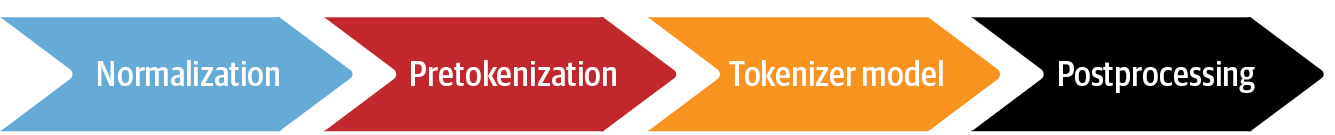

In [44]:
url_to_image('https://camo.githubusercontent.com/e24eb4651afde309f50348e6d9721698e3bbdb621462ce53f428e5e550148a29/68747470733a2f2f6769746875622e636f6d2f7269636b69657061726b2f6e6c702d776974682d7472616e73666f726d6572732f626c6f622f6d61696e2f696d616765732f6368617074657230345f746f6b656e697a65722d706970656c696e652e706e673f7261773d31')

- 정규화 : 원시 문자열을 더 깨끗하게 만들기 위해 적용하는 일련의 연산

- 사전 토큰화(pretokenization) : 텍스트를 더 작은 객체로 분할하며 훈련 마지막에 생성되는 토큰의 상한선을 제공
> 사전 토큰화가 텍스트를 단어로 분할하고 최종 토큰은 이 단어의 일부가 됨

- 토크나이저 모델(Tokenzier model) : 입력 텍스트 정규화와 사전 토큰화를 수행하고 난 후 토크나이저를 사용해 부분 단어 분할 모델을 단어에 적용
> 부분 단어 분할 모델 : BPE, Unigram, wordpiece 등
> 부분 단어 분할 모델을 사용해 vocab_size와 OOV token(unk)의 개수 감소

- 사후 처리(post processing) : 토큰화 파이프라인의 마지막 단계로, 토큰 리스트에 부가적 변환 적용
> ex) 입력 토큰 인덱스의 시퀀스 처음과 끝에 특수 토큰을 추가하는 경우

## SentencePiece Tokenizer

In [ ]:
"".join(xlmr_tokens).replace(u"/u2581","")

- sentencePiece 토크나이저는 유니그램이라는 부분단어 분할 방식을 기반으로 각 입력 텍스트를 유니코드 문자 시퀀스로 인코딩

- Sentencepiece는 공백 문자가 유니코드 기호 U+2581 또는 아래 1/4 블록 문자라고 하는(_) 문자에 할당